In [1]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'PredictionsMLL.txt'
Data = pd.read_csv(file_path, sep=',')

Data['redundancy'] = round(Data['redundancy'], 1)
Data['relevance'] = round(Data['relevance'], 1)

# Display the contents of the DataFrame
print("Max AUC score",Data['AUCScore'].max())
print("Max Accuracy score",Data['AccuracyScore'].max())
print("Max AUC score",Data['AUCScore'].min())

Max AUC score 100.0
Max Accuracy score 100.0
Max AUC score 39.1


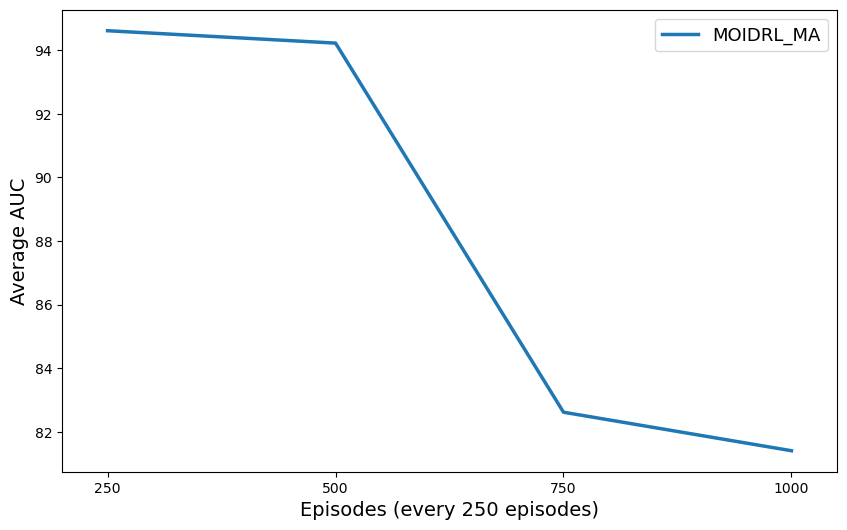

In [2]:
# Grouping data into chunks of 250 episodes and calculating the average reward
average_reward = Data.groupby(Data.index // 250)['AUCScore'].mean()

x_ticks = [250 * i for i in range(1, len(average_reward) + 1)]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_ticks,average_reward, label='MOIDRL_MA',linewidth=2.5)

# Adding labels and title with increased font size
ax.set_xlabel('Episodes (every 250 episodes)', fontsize=14)
ax.set_ylabel('Average AUC', fontsize=14)
# ax.set_title("MLL", fontsize=16)

# Adding a legend with increased font size
ax.legend(fontsize=13)
# Setting the axis limits (échelle)
ax.set_xlim([200, 1050]) 

ax.set_xticks(x_ticks)

# plt.savefig('AUCBreast.pdf', format='pdf',dpi=800)  # Change dpi for higher resolution, e.g., 300, 600

# Show the plot
plt.show()

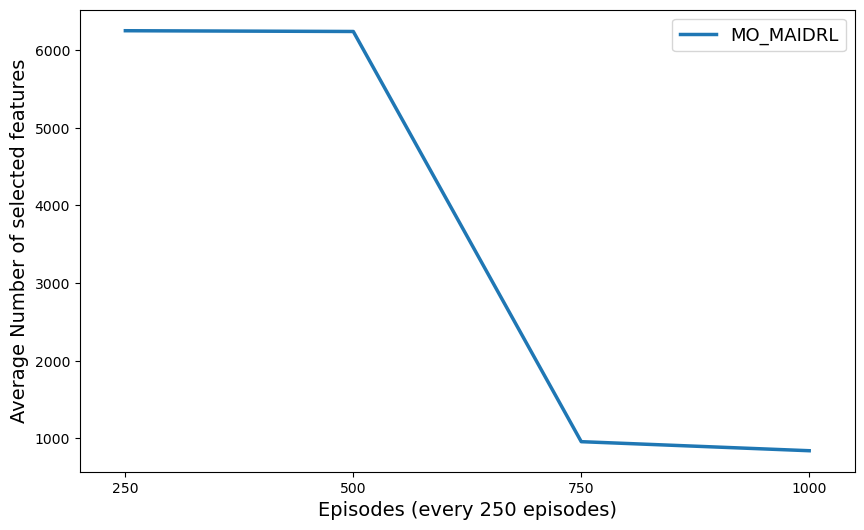

In [3]:
# Grouping data into chunks of 100 episodes and calculating the average reward
average_reward = Data.groupby(Data.index // 250)['FeatureNumber'].mean()

x_ticks = [250 * i for i in range(1, len(average_reward) + 1)]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_ticks,average_reward, label='MO_MAIDRL',linewidth=2.5)

ax.set_xlabel('Episodes (every 250 episodes)', fontsize=14)
ax.set_ylabel('Average Number of selected features', fontsize=14)
ax.legend(fontsize=13)

ax.set_xlim([200, 1050]) 
ax.set_xticks(x_ticks)
# plt.savefig('Fig03-6734.pdf', format='pdf',dpi=600)  # Change dpi for higher resolution, e.g., 300, 600
plt.show()

Text(0.5, 1.0, 'Data')

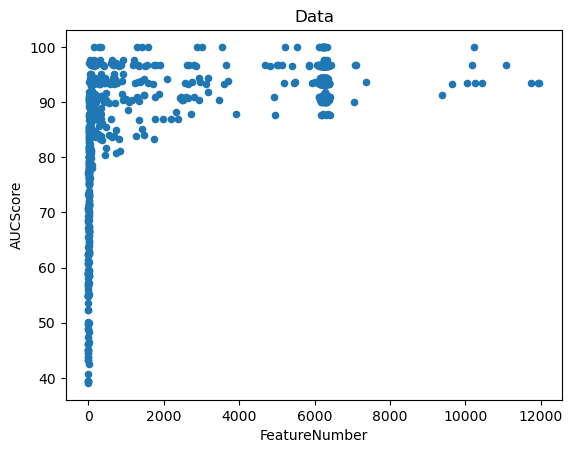

In [4]:
ax = Data.plot.scatter(x='FeatureNumber', y='AUCScore')
ax.set_title('Data')

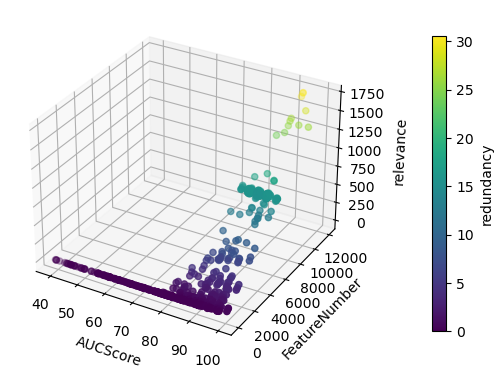

In [5]:
# Creating the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(Data['AUCScore'], Data['FeatureNumber'], Data['relevance'], c=Data['redundancy'], cmap='viridis')

# Adjusting the color bar position
# You can tweak the `shrink` parameter or `pad` to move the color bar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, pad=0.15)  # Shrink makes the bar smaller; pad controls distance
cbar.set_label('redundancy')  # Color bar label

# Labels
ax.set_xlabel('AUCScore')
ax.set_ylabel('FeatureNumber')
ax.set_zlabel('relevance',labelpad=7)

# plt.tight_layout()
# Show plot
plt.show()


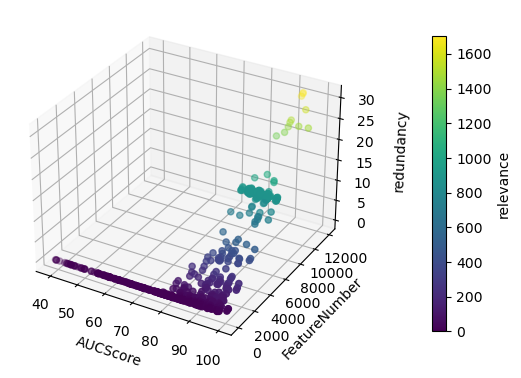

In [6]:
# Creating the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(Data['AUCScore'], Data['FeatureNumber'], Data['redundancy'], c=Data['relevance'], cmap='viridis')

# Adjusting the color bar position
# You can tweak the `shrink` parameter or `pad` to move the color bar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, pad=0.15)  # Shrink makes the bar smaller; pad controls distance
cbar.set_label('relevance')  # Color bar label

# Labels
ax.set_xlabel('AUCScore')
ax.set_ylabel('FeatureNumber')
ax.set_zlabel('redundancy',labelpad=7)

# plt.tight_layout()
# Show plot
plt.show()

In [7]:
def count_diffs(a, b, to_min, to_max):
    n_better = 0
    n_worse = 0

    for f in to_min:
        n_better += a[f] < b[f]
        n_worse += a[f] > b[f]

    for f in to_max:
        n_better += a[f] > b[f]
        n_worse += a[f] < b[f]

    return n_better, n_worse

def find_skyline_bnl(df, to_min, to_max):
    """Finds the skyline using a block-nested loop with 4 objectives."""

    rows = df.to_dict(orient='index')

    # Use the first row to initialize the skyline
    skyline = {df.index[0]}

    # Loop through the rest of the rows
    for i in df.index[1:]:

        to_drop = set()
        is_dominated = False

        for j in skyline:

            n_better, n_worse = count_diffs(rows[i], rows[j], to_min, to_max)

            # Case 1: Current row i is dominated by row j
            if n_worse > 0 and n_better == 0:
                is_dominated = True
                break

            # Case 2: Row i dominates row j
            if n_better > 0 and n_worse == 0:
                to_drop.add(j)

        if is_dominated:
            continue

        # Remove dominated rows from the skyline
        skyline = skyline.difference(to_drop)
        # Add the current row i to the skyline
        skyline.add(i)

    return pd.Series(df.index.isin(skyline), index=df.index)

In [8]:
import time

tic = time.time()
skyline = find_skyline_bnl(df=Data, to_min=["FeatureNumber", "redundancy"], to_max=["AUCScore", "relevance"])
print(f'Block nested loop took {time.time() - tic:.3f} seconds', skyline)

Block nested loop took 0.062 seconds 0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997     True
998    False
999    False
Length: 1000, dtype: bool


In [9]:
selected_items = []

for index, is_skyline in skyline.items():
    if is_skyline:
        selected_items.append(index)

print("Length of selected items:", len(selected_items), selected_items)

selected_data = Data.loc[selected_items]
# Save the merged DataFrame to a CSV file
selected_data.to_csv('Result_MLL.csv', index=False)

Length of selected items: 255 [42, 44, 60, 77, 105, 114, 122, 125, 133, 141, 145, 164, 166, 168, 170, 171, 185, 204, 227, 238, 239, 244, 251, 252, 261, 268, 273, 295, 305, 308, 311, 317, 321, 326, 344, 391, 398, 399, 419, 429, 439, 446, 448, 458, 462, 463, 469, 470, 477, 487, 493, 498, 501, 502, 503, 504, 505, 507, 515, 516, 517, 518, 521, 523, 528, 529, 530, 531, 532, 533, 541, 542, 543, 544, 545, 546, 554, 555, 556, 558, 561, 562, 563, 565, 569, 570, 571, 572, 573, 579, 580, 581, 582, 583, 594, 595, 596, 597, 606, 609, 611, 613, 627, 628, 629, 630, 631, 642, 645, 646, 648, 663, 664, 665, 666, 667, 668, 680, 681, 682, 686, 690, 691, 692, 693, 695, 696, 700, 701, 702, 703, 704, 706, 709, 710, 711, 712, 713, 714, 716, 717, 726, 727, 730, 731, 736, 737, 738, 739, 740, 741, 742, 743, 755, 756, 758, 766, 767, 768, 769, 770, 772, 775, 776, 778, 779, 780, 781, 782, 783, 784, 786, 787, 789, 791, 792, 793, 794, 795, 796, 797, 799, 806, 807, 808, 810, 811, 818, 819, 821, 822, 823, 824, 825, 831

In [10]:
print("AUCScore: ")
print("min", Data['AUCScore'].min())
print("max",Data['AUCScore'].max())
print("std",Data['AUCScore'].std())
print("mean",Data['AUCScore'].mean())

AUCScore: 
min 39.1
max 100.0
std 12.092062697914303
mean 88.2137


In [11]:
print("FeatureNumber : ")
print("min", Data['FeatureNumber'].min())
print("max",Data['FeatureNumber'].max())
print("std",Data['FeatureNumber'].std())
print("mean",Data['FeatureNumber'].mean())

FeatureNumber : 
min 1
max 11959
std 3024.1571460564096
mean 3572.02


In [12]:
df_selected_data = selected_data[
    (selected_data['AUCScore'] > (selected_data['AUCScore'].mean())) &
    (selected_data['FeatureNumber'] < (selected_data['FeatureNumber'].std()))
]
df_selected_data

,AccuracyScore,Reward,AUCScore,FeatureNumber,PrecisionScore,RecallScore,f1Score,relevance,redundancy,selected_features1
502,92.3,2375761.8,93.5,1580,92.3,92.3,92.3,231.1,3.9,"[0, 8198, 10, 17, 19, 8215, 8220, 35, 41, 44, ..."
503,92.3,609623.7,93.5,756,92.3,92.3,92.3,110.4,1.8,"[0, 8198, 10250, 4106, 4109, 2065, 2066, 19, 4..."
504,96.2,139764.8,96.7,387,96.2,96.2,96.2,58.5,1.0,"[0, 8198, 10250, 4106, 4109, 2065, 8215, 10265..."
517,100.0,8366119.1,100.0,2873,100.0,100.0,100.0,406.6,7.4,"[1, 4, 8201, 8202, 11, 13, 14, 15, 17, 25, 821..."
518,100.0,2021468.8,100.0,1409,100.0,100.0,100.0,201.6,3.6,"[1, 4, 8201, 8202, 11, 15, 17, 8218, 8222, 823..."
...,...,...,...,...,...,...,...,...,...,...
946,96.2,43881.7,97.0,201,96.2,96.2,96.2,27.2,0.5,"[5632, 8707, 7173, 12306, 2067, 6678, 5142, 11..."
957,96.2,2456907.7,96.7,1559,96.2,96.2,96.2,220.3,3.8,"[8196, 8206, 8210, 19, 8212, 8224, 8226, 8231,..."
971,92.3,7341536.2,93.6,2738,92.3,92.3,92.3,385.9,7.2,"[3, 6, 8199, 8209, 22, 25, 32, 37, 8231, 8232,..."
972,92.3,1836939.9,93.6,1366,92.3,92.3,92.3,195.3,3.5,"[6, 8199, 25, 32, 37, 8231, 8232, 8241, 51, 82..."


In [13]:
sorted_skyline = df_selected_data.sort_values(by=['AUCScore', 'FeatureNumber'], ascending=[False, True])
sorted_skyline

,AccuracyScore,Reward,AUCScore,FeatureNumber,PrecisionScore,RecallScore,f1Score,relevance,redundancy,selected_features1
797,100.0,24540.4,100.0,159,100.0,100.0,100.0,21.8,0.5,"[8193, 3073, 1026, 10758, 4616, 4109, 9742, 11..."
865,100.0,88252.4,100.0,288,100.0,100.0,100.0,40.3,0.7,"[12288, 5120, 2051, 5127, 5641, 8202, 4618, 52..."
905,100.0,111133.0,100.0,334,100.0,100.0,100.0,46.2,0.7,"[32, 10278, 2093, 12335, 57, 12355, 4169, 1236..."
794,100.0,1665663.5,100.0,1293,100.0,100.0,100.0,184.6,3.3,"[8192, 8193, 8194, 8196, 9, 15, 18, 8214, 24, ..."
518,100.0,2021468.8,100.0,1409,100.0,100.0,100.0,201.6,3.6,"[1, 4, 8201, 8202, 11, 15, 17, 8218, 8222, 823..."
...,...,...,...,...,...,...,...,...,...,...
532,92.3,321231.9,93.3,566,92.3,92.3,92.3,81.2,1.5,"[12288, 10241, 6157, 4111, 10255, 4113, 22, 82..."
582,92.3,2924803.6,93.3,1701,92.3,92.3,92.3,251.7,4.2,"[8192, 1, 8197, 8206, 17, 8216, 32, 8224, 39, ..."
766,92.3,-6814231.6,93.3,2639,92.3,92.3,92.3,380.8,6.9,"[3882, 1294, 4848, 3375, 1678, 156, 10486, 240..."
706,92.3,6108.7,93.2,96,92.3,92.3,92.3,16.3,0.2,"[6149, 7698, 11284, 5653, 5151, 9763, 7725, 10..."


In [14]:
sorted_skyline.to_csv("paretoFront_MLL.csv", index=False)

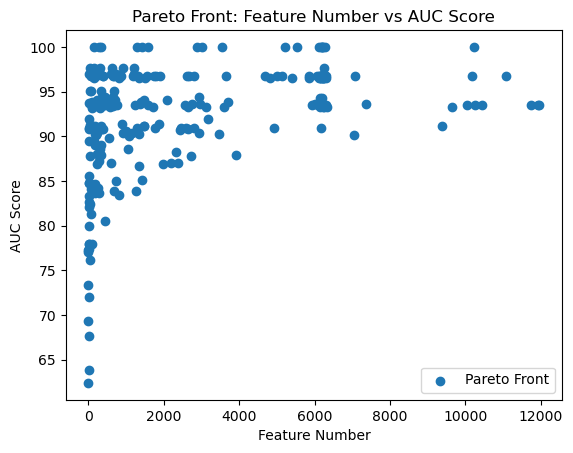

In [15]:
import matplotlib.pyplot as plt

plt.scatter(Data.loc[skyline, 'FeatureNumber'], Data.loc[skyline, 'AUCScore'], label='Pareto Front')
plt.xlabel('Feature Number')
plt.ylabel('AUC Score')
plt.title('Pareto Front: Feature Number vs AUC Score')
plt.legend()
plt.show()


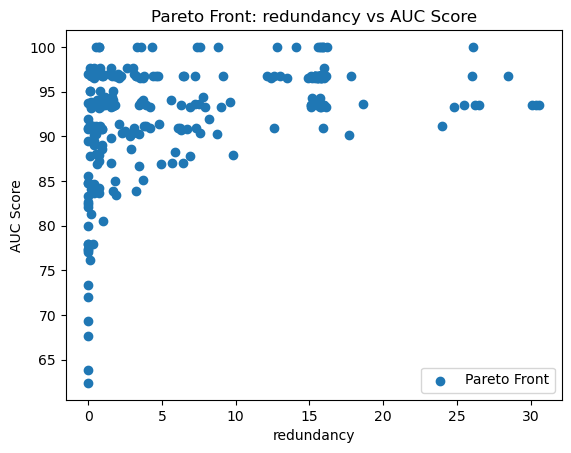

In [16]:
plt.scatter(Data.loc[skyline, 'redundancy'], Data.loc[skyline, 'AUCScore'], label='Pareto Front')
plt.xlabel('redundancy')
plt.ylabel('AUC Score')
plt.title('Pareto Front: redundancy vs AUC Score')
plt.legend()
plt.show()

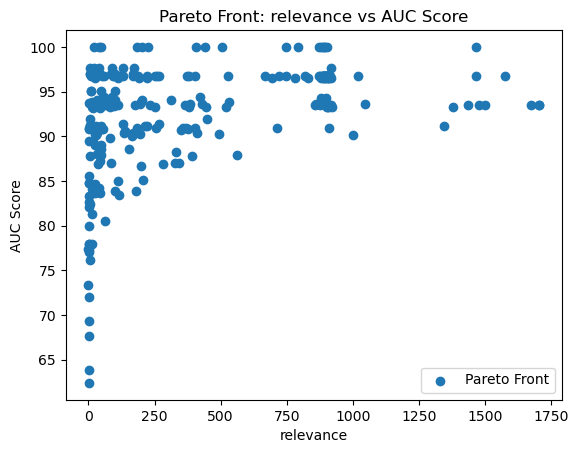

In [17]:
plt.scatter(Data.loc[skyline, 'relevance'], Data.loc[skyline, 'AUCScore'], label='Pareto Front')
plt.xlabel('relevance')
plt.ylabel('AUC Score')
plt.title('Pareto Front: relevance vs AUC Score')
plt.legend()
plt.show()

In [18]:
from sklearn.cluster import KMeans
import numpy as np

# Extract Pareto front points from your DataFrame
pareto_solutions = Data[skyline]

numeric_columns = pareto_solutions.select_dtypes(include=[np.number]).columns
pareto_solutions_numeric = pareto_solutions[numeric_columns]

# Apply KMeans clustering to reduce the number of solutions
n_clusters = 4  # Number of clusters you want to represent the Pareto front
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(pareto_solutions_numeric)

# Get the cluster centers (representative points)
representative_solutions = pd.DataFrame(kmeans.cluster_centers_, columns=pareto_solutions_numeric.columns)
representative_solutions

,AccuracyScore,Reward,AUCScore,FeatureNumber,PrecisionScore,RecallScore,f1Score,relevance,redundancy
0,90.025764,8.683103e+05,92.054585,2119.965066,90.025764,90.025764,90.025764,306.329694,5.364192
1,93.363636,-1.112582e+08,94.463636,10622.818182,93.363636,93.363636,93.363636,1520.100000,27.154545
2,95.700000,2.817998e+07,96.312500,5326.500000,95.700000,95.700000,95.700000,765.712500,13.525000
3,93.985714,-3.811346e+07,94.942857,6172.285714,93.985714,93.985714,93.985714,881.657143,15.628571


In [19]:
from sklearn.cluster import KMeans
import numpy as np

columns_to_select = ['AUCScore', 'FeatureNumber', 'relevance', 'redundancy']

pareto_solutions = df_selected_data[columns_to_select]

numeric_columns = pareto_solutions.select_dtypes(include=[np.number]).columns
pareto_solutions_numeric = pareto_solutions[numeric_columns]

# Apply KMeans clustering to reduce the number of solutions
n_clusters = 10  # Number of clusters you want to represent the Pareto front
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(pareto_solutions_numeric)

# Get the cluster centers (representative points)
representative_solutions = pd.DataFrame(kmeans.cluster_centers_, columns=pareto_solutions_numeric.columns)
representative_solutions

,AUCScore,FeatureNumber,relevance,redundancy
0,97.000000,185.142857,26.900000,0.485714
1,95.783333,1448.500000,206.800000,3.650000
2,95.650000,2729.750000,389.662500,6.962500
3,95.220000,641.800000,92.240000,1.610000
4,96.060000,1683.400000,243.920000,4.280000
5,95.513333,357.266667,51.420000,0.893333
6,96.885714,1255.000000,179.300000,3.242857
7,95.478571,66.857143,10.478571,0.135714
8,96.450000,808.500000,114.675000,2.062500
9,95.450000,1999.000000,290.750000,5.150000
